In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=20


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-5
e2 = 1e-6
nmax_iter = int(dim/5)
restart   = 64

# sigma=0.02
sigma=0.2


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =2000
InputDim=dim*dim
HiddenDim=dim*dim
OutputDim=dim*dim

In [4]:
# check 2d grid and RHS


import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D


fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=200

# Z=np.sin(1)*X+np.cos(1)*Y

xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z)

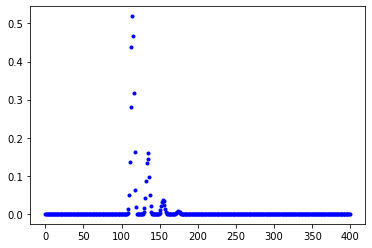

In [5]:
# Check that we flatten according to Fortran ordering(columnwise) 

Z[:,0:5]=0
b_test=np.reshape(Z.T,(1,-1),order='C')
b_norm=np.linalg.norm(b_test)
# print(b_test)
pp.plot((b_test.T)/b_norm,'.b')

In [6]:
# Initial log message
logger.info("Test 2D-Flat problem using 1DConv +1 FC. Dim 20. Wide point source constrained on rose k=6.  e1=10^{-5}. Epochs 2000")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-27 01:46:54 [INFO] <ipython-input-6-7d98209200c5> 2 - Test 2D-Flat problem using 1DConv +1 FC. Dim 20. Wide point source constrained on rose k=6.  e1=10^{-5}. Epochs 2000


In [7]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2DFlat(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b,b_flat ,x0,e,nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,ML_GMRES_Time_list2):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [8]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]

eps=0.0001

for ProbIdx in range(n_steps):

    xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
    yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

#     b=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))


    b_flat=np.reshape(b.T,(1,-1),order='C').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm,b_flat/b_norm ,x0,e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,ML_GMRES_Time_list2)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    trainTime_list.append(OutList1[2])
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,b_flat/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,ML_GMRES_Time_list2)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    ML_GMRES_Time_list2=OutList2[6]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[2])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)

MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)

logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
2
3
4
Final loss: 9.703247997094877e-06
parameters 320400
Initial Training
5
size 2
0.5581827529423663 0.8531615924339866
0.8173202129837591 0.5923350093362387 1.0795227155127511 0.837479427150599
0.8173202129837591 0.5923350093362387 1.0795227155127511 0.837479427150599
6
size 2
0.5577655745013103 1.0795227155127511
0.43082814299850725 0.6485813102481188 0.31705283872265316 0.897990249241137
0.43082814299850725 0.6485813102481188 0.31705283872265316 0.897990249241137
7
size 2
0.4967414838808349 1.0795227155127511
0.9184092019859236 0.6087563719993341 1.6278745960529366 0.7754569945813106
0.9184092019859236 0.6087563719993341 1.6278745960529366 0.7754569945813106
8
size 2
0.4873084911348241 1.6278745960529366
0.2696005449979566 0.670686937996652 1.567211730213642 0.9459405148756357
0.2696005449979566 0.670686937996652 1.567211730213642 0.9459405148756357
9
size 2
0.47731880671705795 1.6278745960529366
0.6880968600162305 0.6050739455968142 1.4680723337998722 1.0887505424315669
0.688

0.3455021929985378 0.6051629271171987 0.08000157635206852 1.1400503040293661
0.3455021929985378 0.6051629271171987 0.08000157635206852 1.1400503040293661
44
size 2
0.4777892756115892 2.0377392276512993
0.43601978599326685 0.5975495994777884 0.11632280827529398 1.0850107361240033
0.43601978599326685 0.5975495994777884 0.11632280827529398 1.0850107361240033
45
size 2
0.4869353072424743 2.0377392276512993
0.5038318379956763 0.5808765797980595 0.2844052823852725 1.0517058338404843
0.5038318379956763 0.5808765797980595 0.2844052823852725 1.0517058338404843
46
size 2
0.4866138750534357 2.0377392276512993
0.46780330801266246 0.5811280333576724 0.20923990882242005 1.0283633538952204
0.46780330801266246 0.5811280333576724 0.20923990882242005 1.0283633538952204
47
size 2
0.5544910249909639 2.0377392276512993
0.4932291730074212 0.5686771989578847 0.3978184485121836 0.9830577364733142
0.4932291730074212 0.5686771989578847 0.3978184485121836 0.9830577364733142
48
size 2
0.5581179100559847 2.0377392

82
size 2
0.5581837820861535 2.0377392276512993
0.41283756302436814 0.5468763472384307 0.18817520574263694 0.771894208097507
0.41283756302436814 0.5468763472384307 0.18817520574263694 0.771894208097507
83
size 2
0.5581760388438463 2.0377392276512993
0.33735325900488533 0.5441762523993384 0.3767088509492753 0.749636151704315
0.33735325900488533 0.5441762523993384 0.3767088509492753 0.749636151704315
84
size 2
0.5449549505988582 2.0377392276512993
0.44636543301749043 0.5419302377593703 0.7357647694666126 0.7082393769291234
0.44636543301749043 0.5419302377593703 0.7357647694666126 0.7082393769291234
85
size 2
0.49104883012297823 2.0377392276512993
0.44688179399236105 0.5311643002799247 0.8389105834231074 0.6990401754930663
0.44688179399236105 0.5311643002799247 0.8389105834231074 0.6990401754930663
86
size 2
0.47176393294974717 2.0377392276512993
0.6036428459919989 0.5294237078796141 0.5514925048703574 0.7195630241977534
0.6036428459919989 0.5294237078796141 0.5514925048703574 0.719563024

122
size 2
0.48248816569698627 2.0377392276512993
0.5565718169964384 0.45627487955614926 0.3465047874813717 0.38807184240689174
0.5565718169964384 0.45627487955614926 0.3465047874813717 0.38807184240689174
123
size 2
0.48527202459886654 2.0377392276512993
0.394200101000024 0.45772593447589316 0.3465580906104206 0.3872021370954664
0.394200101000024 0.45772593447589316 0.3465580906104206 0.3872021370954664
124
size 2
0.5285143364823519 2.0377392276512993
0.4702311269938946 0.4498151601164136 0.24932920079184842 0.35266011504160266
0.4702311269938946 0.4498151601164136 0.24932920079184842 0.35266011504160266
125
size 2
0.5544804644892857 2.0377392276512993
0.40073303200188093 0.4440160500362981 0.6804540291979645 0.35531937833717764
0.40073303200188093 0.4440160500362981 0.6804540291979645 0.35531937833717764
126
size 2
0.5581799298497192 2.0377392276512993
0.4294692749972455 0.439497518556891 0.2341356994756004 0.3654633716073558
0.4294692749972455 0.439497518556891 0.2341356994756004 0.

0.41445017300429754 0.42189805463887753 0.2601494700617019 0.33633832516835377
161
size 2
0.557790412219809 2.0377392276512993
0.41097035401617177 0.4164077610790264 0.42417173529368285 0.31638569675507733
0.41097035401617177 0.4164077610790264 0.42417173529368285 0.31638569675507733
162
size 2
0.5307937726660007 2.0377392276512993
0.28984756499994546 0.42050151919946077 0.29508929887193797 0.31061661218880254
0.28984756499994546 0.42050151919946077 0.29508929887193797 0.31061661218880254
163
size 2
0.4875146768161983 2.0377392276512993
0.40855280100367963 0.4134349105600268 0.4551992997955776 0.3053014257027894
0.40855280100367963 0.4134349105600268 0.4551992997955776 0.3053014257027894
164
size 2
0.47463173644631457 2.0377392276512993
0.32683532300870866 0.4153817119600717 0.18822483306738153 0.3157077081820125
0.32683532300870866 0.4153817119600717 0.18822483306738153 0.3157077081820125
165
size 2
0.4792468187026998 2.0377392276512993
0.36814720401889645 0.41222749392152763 0.121341

Final loss: 0.0013798428699374199
parameters 320400
198
size 2
0.48066724534519545 2.0377392276512993
0.42060440199566074 0.4248119815613609 0.15594878982216284 0.26065683398197975
0.42060440199566074 0.4248119815613609 0.15594878982216284 0.26065683398197975
199
size 2
0.4788827223851812 2.0377392276512993
0.6532231630117167 0.41676986356033013 0.3524976825515923 0.2507109905887749
0.6532231630117167 0.41676986356033013 0.3524976825515923 0.2507109905887749
200
size 2
0.47245051262756665 2.0377392276512993
0.43111900199437514 0.4255817493598443 0.22773209893604993 0.2566091136818819
0.43111900199437514 0.4255817493598443 0.22773209893604993 0.2566091136818819
201
size 2
0.48226494675428977 2.0377392276512993
0.46867823897628114 0.41543446031981146 0.26781664950965706 0.25063617994887455
0.46867823897628114 0.41543446031981146 0.26781664950965706 0.25063617994887455
202
size 2
0.5242162000917919 2.0377392276512993
0.4227713339787442 0.41699864019872623 0.20674395358219153 0.25094380588

0.2824220519978553 0.39105885556549763 0.11491824014180521 0.17918712984691978
0.2824220519978553 0.39105885556549763 0.11491824014180521 0.17918712984691978
236
size 2
0.5544283951400452 2.0377392276512993
0.3319580809911713 0.3895302820857614 0.17254429254469758 0.1765317398740942
0.3319580809911713 0.3895302820857614 0.17254429254469758 0.1765317398740942
237
size 2
0.5581828387765378 2.0377392276512993
0.3009389789949637 0.3872172842454165 0.12808671657911674 0.17401955935938232
0.3009389789949637 0.3872172842454165 0.12808671657911674 0.17401955935938232
238
size 2
0.5581822846780162 2.0377392276512993
0.26074375500320457 0.38466129440581426 0.06049685125605296 0.16677414643084545
0.26074375500320457 0.38466129440581426 0.06049685125605296 0.16677414643084545
239
size 2
0.5558508756736557 2.0377392276512993
0.3415879579843022 0.38102812408586034 0.1730627788598705 0.16373166400227976
0.3415879579843022 0.38102812408586034 0.1730627788598705 0.16373166400227976
240
size 2
0.5345798

Final loss: 0.0028965752571821213
parameters 320400
274
size 2
0.48835360954889806 2.0377392276512993
0.22470511400024407 0.33743414395838045 0.06664000985317343 0.17146944550676912
0.22470511400024407 0.33743414395838045 0.06664000985317343 0.17146944550676912
275
size 2
0.4851713524703085 2.0377392276512993
0.2450402319955174 0.33359752263757403 0.05136159407333165 0.16934214190355212
0.2450402319955174 0.33359752263757403 0.05136159407333165 0.16934214190355212
276
size 2
0.477804222366058 2.0377392276512993
0.34402090101502836 0.3338025767577346 0.05777153105677071 0.16585166537187152
0.34402090101502836 0.3338025767577346 0.05777153105677071 0.16585166537187152
277
size 2
0.4587480482946114 2.0377392276512993
0.3061833719839342 0.3348160397983156 0.07195506199946256 0.1603905071529724
0.3061833719839342 0.3348160397983156 0.07195506199946256 0.1603905071529724
278
size 2
0.4726457552647713 2.0377392276512993
0.33475879597244784 0.33704292599810287 0.19855183309928554 0.15413596153

312
size 2
0.4859056203999673 2.0377392276512993
0.2686805480043404 0.32175327063770964 0.14408389659530016 0.11251386342566425
0.2686805480043404 0.32175327063770964 0.14408389659530016 0.11251386342566425
313
size 2
0.5178580478564969 2.0377392276512993
0.41343375900760293 0.3200392846378963 0.14522570543182828 0.11602713603937649
0.41343375900760293 0.3200392846378963 0.14522570543182828 0.11602713603937649
314
size 2
0.5580969771878097 2.0377392276512993
0.24221996299456805 0.31874695235863326 0.14040290526029953 0.11888885639358268
0.24221996299456805 0.31874695235863326 0.14040290526029953 0.11888885639358268
315
size 2
0.558183806682696 2.0377392276512993
0.2605954059981741 0.31828711459878833 0.08358388753746267 0.12232776485750882
0.2605954059981741 0.31828711459878833 0.08358388753746267 0.12232776485750882
316
size 2
0.5581524278245521 2.0377392276512993
0.21254191899788566 0.30756635779864155 0.059351742759442876 0.1212733036381499
0.21254191899788566 0.30756635779864155 0.

349
size 2
0.5581811553268142 2.0377392276512993
0.1517078279866837 0.3012971453613136 0.08436936395867012 0.08634954374220975
0.1517078279866837 0.3012971453613136 0.08436936395867012 0.08634954374220975
350
size 2
0.5575094632956386 2.0377392276512993
0.200893292989349 0.2946668124012649 0.21716018399817424 0.0860745726776546
0.200893292989349 0.2946668124012649 0.21716018399817424 0.0860745726776546
351
size 2
0.49193532219119973 2.0377392276512993
0.25855752400821075 0.2902267437602859 0.15626690440084026 0.08466052997013444
0.25855752400821075 0.2902267437602859 0.15626690440084026 0.08466052997013444
352
size 2
0.48765738968682276 2.0377392276512993
0.26933074998669326 0.29196246196050196 0.03553748449305125 0.08721985099135948
0.26933074998669326 0.29196246196050196 0.03553748449305125 0.08721985099135948
353
size 2
0.4775403094757126 2.0377392276512993
0.2915469139989 0.29354679376003334 0.14389748983614534 0.08548428477552865
0.2915469139989 0.29354679376003334 0.1438974898361

388
size 2
0.47777896655031715 2.0377392276512993
0.1915926070068963 0.2641289874434005 0.030275525726667536 0.06799123087178288
0.1915926070068963 0.2641289874434005 0.030275525726667536 0.06799123087178288
389
size 2
0.48736784845482406 2.0377392276512993
0.5039139740110841 0.2584006780036725 0.1395116445840712 0.0629399906276822
0.5039139740110841 0.2584006780036725 0.1395116445840712 0.0629399906276822
390
size 2
0.48618129958623074 2.0377392276512993
0.20232981198932976 0.2684422534436453 0.12617130608860463 0.06760789839079377
0.20232981198932976 0.2684422534436453 0.12617130608860463 0.06760789839079377
391
size 2
0.5556770290672589 2.0377392276512993
0.3013366350205615 0.26812884880346244 0.15034953695955677 0.07188385272349528
0.3013366350205615 0.26812884880346244 0.15034953695955677 0.07188385272349528
InnerProd [[1.         0.33573865 0.68062508]
 [0.33573865 1.         0.52667646]
 [0.68062508 0.52667646 1.        ]]
retraining
3
Final loss: 0.006877084728330374
parameters

425
size 2
0.5579284845038667 2.0377392276512993
0.17341869900701568 0.31653908963664434 0.12048808162632964 0.07352617931441054
0.17341869900701568 0.31653908963664434 0.12048808162632964 0.07352617931441054
426
size 2
0.5581838361449776 2.0377392276512993
0.2842201149906032 0.3137635573174339 0.05611220169799441 0.07734281690048343
0.2842201149906032 0.3137635573174339 0.05611220169799441 0.07734281690048343
427
size 2
0.5581691878566973 2.0377392276512993
0.32074095599818975 0.31255331687745636 0.04365090243634848 0.07542572645376602
0.32074095599818975 0.31255331687745636 0.04365090243634848 0.07542572645376602
428
size 2
0.5396390244410773 2.0377392276512993
0.3185411760059651 0.3075095500377938 0.15604591262726178 0.0746879283939425
0.3185411760059651 0.3075095500377938 0.15604591262726178 0.0746879283939425
InnerProd [[1.         0.94356088 0.74455061]
 [0.94356088 1.         0.60282458]
 [0.74455061 0.60282458 1.        ]]
retraining
3
Final loss: 0.002420715754851699
parameter

462
size 2
0.49925988278749905 2.0377392276512993
0.2724742409773171 0.28349384580156767 0.11164950291551766 0.0670455369808723
0.2724742409773171 0.28349384580156767 0.11164950291551766 0.0670455369808723
463
size 2
0.47160990354423893 2.0377392276512993
0.3209406710229814 0.28426367764011956 0.031613728634161856 0.06914000175383818
0.3209406710229814 0.28426367764011956 0.031613728634161856 0.06914000175383818
464
size 2
0.4640140317004389 2.0377392276512993
0.25128033498185687 0.2900617423618678 0.03589047380336014 0.06841909412300316
0.25128033498185687 0.2900617423618678 0.03589047380336014 0.06841909412300316
465
size 2
0.47799951909358124 2.0377392276512993
0.23022993400809355 0.28946274116053244 0.08847233006130216 0.06615021836427001
0.23022993400809355 0.28946274116053244 0.08847233006130216 0.06615021836427001
466
size 2
0.48314708973256265 2.0377392276512993
0.33627738000359386 0.2860155498003587 0.02746611270122768 0.0683320887905539
0.33627738000359386 0.2860155498003587 

498
size 2
0.47858313764168 2.0377392276512993
0.26465150399599224 0.25097900671884416 0.02991619825817637 0.05661648293358272
0.26465150399599224 0.25097900671884416 0.02991619825817637 0.05661648293358272
499
size 2
0.4812313464451918 2.0377392276512993
0.3854339570098091 0.24819511583889833 0.045882118992512815 0.05495413709793339
0.3854339570098091 0.24819511583889833 0.045882118992512815 0.05495413709793339
500
size 2
0.4823451112170861 2.0377392276512993
0.16364714098745026 0.25592448631883596 0.09178064611787805 0.05584536154557914
0.16364714098745026 0.25592448631883596 0.09178064611787805 0.05584536154557914
501
size 2
0.5146767483329368 2.0377392276512993
0.26563753600930795 0.25759302227874287 0.09896418471775532 0.05887510623006981
0.26563753600930795 0.25759302227874287 0.09896418471775532 0.05887510623006981
InnerProd [[1.         0.49050343 0.96649603]
 [0.49050343 1.         0.42019352]
 [0.96649603 0.42019352 1.        ]]
retraining
2
Final loss: 0.00396766560152173
pa

536
size 2
0.557979934908206 2.0377392276512993
0.47754459601128474 0.25390691452194003 0.09483191042082681 0.046439264379976676
0.47754459601128474 0.25390691452194003 0.09483191042082681 0.046439264379976676
InnerProd [[1.         0.89807469 0.78587899]
 [0.89807469 1.         0.88173779]
 [0.78587899 0.88173779 1.        ]]
retraining
2
Final loss: 0.00422592181712389
parameters 320400
537
size 2
0.558183849283505 2.0377392276512993
0.24651711698970757 0.2576243937225081 0.03377607765948359 0.048588959085796087
0.24651711698970757 0.2576243937225081 0.03377607765948359 0.048588959085796087
538
size 2
0.5580848259758997 2.0377392276512993
0.3826352169853635 0.25679547184263357 0.06892706118335293 0.04813257183869795
0.3826352169853635 0.25679547184263357 0.06892706118335293 0.04813257183869795
539
size 2
0.5420735145472075 2.0377392276512993
0.26992905299994163 0.26094234408228656 0.03413122043732109 0.04747117594204381
0.26992905299994163 0.26094234408228656 0.03413122043732109 0.04

572
size 2
0.552566956783859 2.0377392276512993
0.4512105800095014 0.25557911455980503 0.0633700658101438 0.05914736256261391
0.4512105800095014 0.25557911455980503 0.0633700658101438 0.05914736256261391
573
size 2
0.5219342935488572 2.0377392276512993
0.16468190602608956 0.2608108499995433 0.03125923560840192 0.05984669679524182
0.16468190602608956 0.2608108499995433 0.03125923560840192 0.05984669679524182
574
size 2
0.48392723563082196 2.0377392276512993
0.14104219499859028 0.26059998788055966 0.01834948065711386 0.05923001083725883
0.14104219499859028 0.26059998788055966 0.01834948065711386 0.05923001083725883
575
size 2
0.48185488729154247 2.0377392276512993
0.12937855499330908 0.2527330151607748 0.017835169642769738 0.056444790207124375
0.12937855499330908 0.2527330151607748 0.017835169642769738 0.056444790207124375
576
size 2
0.4783314772810755 2.0377392276512993
0.21954594500130042 0.24859641248127445 0.021661764487249453 0.05505087976617547
0.21954594500130042 0.248596412481274

608
size 2
0.48383595124576056 2.0377392276512993
0.14312538300873712 0.25330634116311557 0.014061451401776922 0.0472226567926012
0.14312538300873712 0.25330634116311557 0.014061451401776922 0.0472226567926012
609
size 2
0.47789852275481726 2.0377392276512993
0.14405479197739623 0.2461858640029095 0.025250801258122475 0.046127295269661285
0.14405479197739623 0.2461858640029095 0.025250801258122475 0.046127295269661285
610
size 2
0.46207873963260737 2.0377392276512993
0.18506721401354298 0.2405140259617474 0.05986152380573817 0.044979474314576925
0.18506721401354298 0.2405140259617474 0.05986152380573817 0.044979474314576925
611
size 2
0.47134254994315494 2.0377392276512993
0.32151893799891695 0.23197653184179218 0.05417109171644476 0.044753205982704575
0.32151893799891695 0.23197653184179218 0.05417109171644476 0.044753205982704575
612
size 2
0.49459103312173375 2.0377392276512993
0.2463349289901089 0.23883454080088995 0.025037471241018686 0.046343249218504384
0.2463349289901089 0.2388

645
size 2
0.48679239292407367 2.0377392276512993
0.169357831007801 0.23388763511902652 0.061338084097495436 0.04470614852648665
0.169357831007801 0.23388763511902652 0.061338084097495436 0.04470614852648665
646
size 2
0.5330272807778819 2.0377392276512993
0.23082134599098936 0.23048321407986805 0.021939084830940394 0.04458632498770981
0.23082134599098936 0.23048321407986805 0.021939084830940394 0.04458632498770981
647
size 2
0.5581564732971277 2.0377392276512993
0.26995535599417053 0.23399326135986484 0.03246496496369984 0.04410112889510942
0.26995535599417053 0.23399326135986484 0.03246496496369984 0.04410112889510942
648
size 2
0.5581838517422831 2.0377392276512993
0.21834815898910165 0.2354070542799309 0.04213442063544126 0.04360503285733522
0.21834815898910165 0.2354070542799309 0.04213442063544126 0.04360503285733522
649
size 2
0.5580529124716356 2.0377392276512993
0.20937299900106154 0.23198351411963813 0.0639470862850217 0.04288882791489018
0.20937299900106154 0.231983514119638

682
size 2
0.5581694860526141 2.0377392276512993
0.2540455739945173 0.22760051287477837 0.0655642946923028 0.04324719242242532
0.2540455739945173 0.22760051287477837 0.0655642946923028 0.04324719242242532
683
size 2
0.5565391645788796 2.0377392276512993
0.16819897998357192 0.22369404455530456 0.06291422976934717 0.044214748566684066
0.16819897998357192 0.22369404455530456 0.06291422976934717 0.044214748566684066
684
size 2
0.4867203814811471 2.0377392276512993
0.22123041900340468 0.22244474655482918 0.05745741390870994 0.04515067397275148
0.22123041900340468 0.22244474655482918 0.05745741390870994 0.04515067397275148
685
size 2
0.4876697485503329 2.0377392276512993
0.19103944499511272 0.2241293977946043 0.0227748214561192 0.04615564862415397
0.19103944499511272 0.2241293977946043 0.0227748214561192 0.04615564862415397
686
size 2
0.4777451100178478 2.0377392276512993
0.2728903880051803 0.22388443911448122 0.029928753223257595 0.04541655536678021
0.2728903880051803 0.22388443911448122 0.

720
size 2
0.4534195542560706 2.0377392276512993
0.20632233502692543 0.21283955959952436 0.03153462167398152 0.028552244140954457
0.20632233502692543 0.21283955959952436 0.03153462167398152 0.028552244140954457
721
size 2
0.47767526278344763 2.0377392276512993
0.19336928401025943 0.21440873976098374 0.009508509934311675 0.028807603187502428
0.19336928401025943 0.21440873976098374 0.009508509934311675 0.028807603187502428
722
size 2
0.487776561546439 2.0377392276512993
0.1606108249980025 0.2111451754812151 0.016229377260331263 0.02840438733331404
0.1606108249980025 0.2111451754812151 0.016229377260331263 0.02840438733331404
723
size 2
0.48852422585023036 2.0377392276512993
0.3563023210153915 0.2100437571608927 0.10748303117071552 0.028226201841415343
0.3563023210153915 0.2100437571608927 0.10748303117071552 0.028226201841415343
InnerProd [[1.         0.44383035 0.70911493]
 [0.44383035 1.         0.63793189]
 [0.70911493 0.63793189 1.        ]]
retraining
3
Final loss: 0.006415252573788

755
size 2
0.4869286285241273 2.0377392276512993
0.2535725859925151 0.23998694372363388 0.034068428291433236 0.031196057295972145
0.2535725859925151 0.23998694372363388 0.034068428291433236 0.031196057295972145
756
size 2
0.48662391396872656 2.0377392276512993
0.1383142980048433 0.24092556920368224 0.019217407966381345 0.03133657042274995
0.1383142980048433 0.24092556920368224 0.019217407966381345 0.03133657042274995
757
size 2
0.5544719343902035 2.0377392276512993
0.41304046398727223 0.24227658772375435 0.06859185443448888 0.03163769602710633
0.41304046398727223 0.24227658772375435 0.06859185443448888 0.03163769602710633
758
size 2
0.5581172643694631 2.0377392276512993
0.2748894930118695 0.2504177544033155 0.05582007081477146 0.03383062873273915
0.2748894930118695 0.2504177544033155 0.05582007081477146 0.03383062873273915
InnerProd [[1.         0.51318515 0.54742919]
 [0.51318515 1.         0.88641501]
 [0.54742919 0.88641501 1.        ]]
retraining
2
Final loss: 0.0019201987888664007

Final loss: 0.0023246705532073975
parameters 320400
792
size 2
0.5581837808881269 2.0377392276512993
0.17267352400813252 0.2243650056864135 0.01471552301978035 0.031042206777503988
0.17267352400813252 0.2243650056864135 0.01471552301978035 0.031042206777503988
793
size 2
0.5581761072094942 2.0377392276512993
0.18414899698109366 0.21720260404632427 0.04849359270967979 0.03018949532975696
0.18414899698109366 0.21720260404632427 0.04849359270967979 0.03018949532975696
794
size 2
0.545019772903173 2.0377392276512993
0.32795603698468767 0.21543573644477873 0.02395065637971334 0.03106296863726651
0.32795603698468767 0.21543573644477873 0.02395065637971334 0.03106296863726651
795
size 2
0.4910910954641073 2.0377392276512993
0.2870195749856066 0.21470651448355058 0.06274115352398842 0.029218524664042442
0.2870195749856066 0.21470651448355058 0.06274115352398842 0.029218524664042442
796
size 2
0.4717545658854849 2.0377392276512993
0.30396661200211383 0.21749528088257647 0.03827057056820196 0.03

0.272290274995612 0.23645927420002408 0.01501163813474443 0.026550340437110336
0.272290274995612 0.23645927420002408 0.01501163813474443 0.026550340437110336
830
size 2
0.4660438510666675 2.0377392276512993
0.12623793701641262 0.23892718703951688 0.01448837349840888 0.025691102197401033
0.12623793701641262 0.23892718703951688 0.01448837349840888 0.025691102197401033
831
size 2
0.47814401020221187 2.0377392276512993
0.23997744999360293 0.23299029284040443 0.016720700911173458 0.02515535305335077
0.23997744999360293 0.23299029284040443 0.016720700911173458 0.02515535305335077
832
size 2
0.4824792548925621 2.0377392276512993
0.10503852300462313 0.22331247588037514 0.009457200066039981 0.023808036388158066
0.10503852300462313 0.22331247588037514 0.009457200066039981 0.023808036388158066
833
size 2
0.4852547153523661 2.0377392276512993
0.162354845990194 0.21794238112051972 0.03969734934681974 0.02314474676697218
0.162354845990194 0.21794238112051972 0.03969734934681974 0.02314474676697218
8

866
size 2
0.48060390759764005 2.0377392276512993
0.1974745789775625 0.1963855273963418 0.017507016925876157 0.02679535962000167
0.1974745789775625 0.1963855273963418 0.017507016925876157 0.02679535962000167
867
size 2
0.5073427426783136 2.0377392276512993
0.20615916399401613 0.1963731836352963 0.01823347054589838 0.0266383647517602
0.20615916399401613 0.1963731836352963 0.01823347054589838 0.0266383647517602
868
size 2
0.5463330885877331 2.0377392276512993
0.14533035099157132 0.1985838991543278 0.021492527417274546 0.02635167690495372
0.14533035099157132 0.1985838991543278 0.021492527417274546 0.02635167690495372
869
size 2
0.5581360590426494 2.0377392276512993
0.28013671800727025 0.1996826282341499 0.06551871850730687 0.02670052968812729
0.28013671800727025 0.1996826282341499 0.06551871850730687 0.02670052968812729
870
size 2
0.5581838270084238 2.0377392276512993
0.241150727000786 0.20133333967532963 0.03810429835454119 0.028494589291235627
0.241150727000786 0.20133333967532963 0.038

0.09223012099391781 0.19831484363530763 0.012656805174328151 0.02771388551861399
903
size 2
0.5581838257260996 2.0377392276512993
0.25837350101210177 0.19414588331477717 0.03607236479211491 0.026883491419256632
0.25837350101210177 0.19414588331477717 0.03607236479211491 0.026883491419256632
904
size 2
0.5581372952585577 2.0377392276512993
0.17955826001707464 0.1928220157150645 0.03745105735789618 0.02601527567339333
0.17955826001707464 0.1928220157150645 0.03745105735789618 0.02601527567339333
905
size 2
0.5464667942019978 2.0377392276512993
0.23069938400294632 0.1928721231967211 0.020302991948540346 0.02692012039295422
0.23069938400294632 0.1928721231967211 0.020302991948540346 0.02692012039295422
906
size 2
0.5075903721588381 2.0377392276512993
0.1909524120274 0.1966576562775299 0.032790363108450536 0.02643692179230519
0.1909524120274 0.1966576562775299 0.032790363108450536 0.02643692179230519
907
size 2
0.4806655513484085 2.0377392276512993
0.08194962999550626 0.1962171952787321 0.0

0.2486331599939149 0.1842594553192612 0.027751912306337757 0.021765690971309253
0.2486331599939149 0.1842594553192612 0.027751912306337757 0.021765690971309253
940
size 2
0.4852979212873743 2.0377392276512993
0.09432503199786879 0.18757133235922083 0.011620232847736896 0.02196755814393463
0.09432503199786879 0.18757133235922083 0.011620232847736896 0.02196755814393463
941
size 2
0.4825015394570659 2.0377392276512993
0.09456931200111285 0.18548079631873407 0.010468293620727806 0.021810780478214248
0.09456931200111285 0.18548079631873407 0.010468293620727806 0.021810780478214248
942
size 2
0.4781383277147651 2.0377392276512993
0.11599487901548855 0.17822827483876608 0.017721045363515216 0.02169660199525997
0.11599487901548855 0.17822827483876608 0.017721045363515216 0.02169660199525997
943
size 2
0.4659735402485382 2.0377392276512993
0.13498412200715393 0.17836880652001127 0.035998258557065885 0.021968941582554687
0.13498412200715393 0.17836880652001127 0.035998258557065885 0.02196894158

975
size 2
0.47783652908856833 2.0377392276512993
0.08205108801485039 0.19025702000129968 0.009527124497047462 0.02159997269877767
0.08205108801485039 0.19025702000129968 0.009527124497047462 0.02159997269877767
976
size 2
0.46031501934062924 2.0377392276512993
0.18177744298009202 0.18932500332128258 0.018798139486574682 0.02151188580365719
0.18177744298009202 0.18932500332128258 0.018798139486574682 0.02151188580365719
977
size 2
0.471778140951926 2.0377392276512993
0.3187657799862791 0.18641413332079537 0.015363017185780434 0.021472528561956198
0.3187657799862791 0.18641413332079537 0.015363017185780434 0.021472528561956198
978
size 2
0.490985781737385 2.0377392276512993
0.1846344140067231 0.18883736087940634 0.02005843069571144 0.021541194708111475
0.1846344140067231 0.18883736087940634 0.02005843069571144 0.021541194708111475
979
size 2
0.5448573062026831 2.0377392276512993
0.15300518600270152 0.19200495739933104 0.012065901088490628 0.022021543466640967
0.15300518600270152 0.19200

0.19648886899813078 0.19650452483794653 0.024735718802919415 0.024282958711126602
0.19648886899813078 0.19650452483794653 0.024735718802919415 0.024282958711126602
1013
size 2
0.5581342642193181 2.0377392276512993
0.19264896601089276 0.19818723559728824 0.029578615042964697 0.02380792985912363
0.19264896601089276 0.19818723559728824 0.029578615042964697 0.02380792985912363
1014
size 2
0.5581838440737578 2.0377392276512993
0.154242186981719 0.19598053943831473 0.02349742930794901 0.024143677646895415
0.154242186981719 0.19598053943831473 0.02349742930794901 0.024143677646895415
1015
size 2
0.5581188677899466 2.0377392276512993
0.17623497999738902 0.19567043151822872 0.02627789083852919 0.024711236638958176
0.17623497999738902 0.19567043151822872 0.02627789083852919 0.024711236638958176
1016
size 2
0.5545195061330548 2.0377392276512993
0.14511692701489665 0.19753363267867827 0.04334122755931684 0.02515861384812196
0.14511692701489665 0.19753363267867827 0.04334122755931684 0.025158613848

Final loss: 0.0031983181834220886
parameters 320400
1050
size 2
0.48861260461621886 2.0377392276512993
0.13392057301825844 0.19766588115948253 0.022590943428707752 0.022802969967981555
0.13392057301825844 0.19766588115948253 0.022590943428707752 0.022802969967981555
1051
size 2
0.4877765693197732 2.0377392276512993
0.31993505300488323 0.19638074635993688 0.02128414394204191 0.022691850676013238
0.31993505300488323 0.19638074635993688 0.02128414394204191 0.022691850676013238
1052
size 2
0.4776719206796156 2.0377392276512993
0.14305075799347833 0.20297608664026484 0.010525076024138368 0.022051335592293643
0.14305075799347833 0.20297608664026484 0.010525076024138368 0.022051335592293643
1053
size 2
0.453411747003261 2.0377392276512993
0.15369808199466206 0.20087083632010036 0.02074065470707264 0.02174001800855486
0.15369808199466206 0.20087083632010036 0.02074065470707264 0.02174001800855486
1054
size 2
0.4773244984784129 2.0377392276512993
0.32201967199216597 0.20041758527979256 0.014415

1087
size 2
0.4777467867854866 2.0377392276512993
0.08263154298765585 0.18887561083887705 0.005995967882273931 0.01946282866025585
0.08263154298765585 0.18887561083887705 0.005995967882273931 0.01946282866025585
1088
size 2
0.4876625348788088 2.0377392276512993
0.14367653999943286 0.17872002043877727 0.009748878970558685 0.018962500541884853
0.14367653999943286 0.17872002043877727 0.009748878970558685 0.018962500541884853
1089
size 2
0.4866815260498799 2.0377392276512993
0.1334114109922666 0.17799061471829192 0.02094711746858956 0.018370787285117138
0.1334114109922666 0.17799061471829192 0.02094711746858956 0.018370787285117138
1090
size 2
0.5565152281645714 2.0377392276512993
0.16484382597263902 0.17641847655759194 0.019176091972600156 0.01868082034736272
0.16484382597263902 0.17641847655759194 0.019176091972600156 0.01868082034736272
1091
size 2
0.5581690906029776 2.0377392276512993
0.33597325801383704 0.1769562224368565 0.03698315791452419 0.018847151543759
0.33597325801383704 0.176

0.35526398397632875 0.198238877520198 0.021855861815811572 0.016734106831734496
0.35526398397632875 0.198238877520198 0.021855861815811572 0.016734106831734496
1124
size 2
0.5580498693192442 2.0377392276512993
0.16222688398556784 0.20153543620021083 0.01890476113345212 0.01721965870153727
0.16222688398556784 0.20153543620021083 0.01890476113345212 0.01721965870153727
1125
size 2
0.5581838516220834 2.0377392276512993
0.1509194100217428 0.203046211960027 0.01646077146919309 0.017666600388275947
0.1509194100217428 0.203046211960027 0.01646077146919309 0.017666600388275947
1126
size 2
0.5581570281423529 2.0377392276512993
0.3354012499912642 0.20250726088066584 0.03304274523864427 0.01777353517680629
0.3354012499912642 0.20250726088066584 0.03304274523864427 0.01777353517680629
InnerProd [[1.         0.7764578  0.81480794]
 [0.7764578  1.         0.95216133]
 [0.81480794 0.95216133 1.        ]]
retraining
2
Final loss: 0.0007070950232446194
parameters 320400
1127
size 2
0.5332647290729525 2

1159
size 2
0.5581798548540801 2.0377392276512993
0.22930813999846578 0.21208081987686456 0.025295287575154483 0.0198665437145179
0.22930813999846578 0.21208081987686456 0.025295287575154483 0.0198665437145179
1160
size 2
0.5492157435835342 2.0377392276512993
0.22344442599569447 0.2134009835566394 0.0205388659109644 0.020077901591002013
0.22344442599569447 0.2134009835566394 0.0205388659109644 0.020077901591002013
1161
size 2
0.49473067696941814 2.0377392276512993
0.2864960209990386 0.2153808289556764 0.019333106206203814 0.019363591197660818
0.2864960209990386 0.2153808289556764 0.019333106206203814 0.019363591197660818
1162
size 2
0.4713386998329364 2.0377392276512993
0.13021803298033774 0.21844726031529718 0.0076201562851824604 0.01934416738673845
0.13021803298033774 0.21844726031529718 0.0076201562851824604 0.01934416738673845
1163
size 2
0.46214106165387064 2.0377392276512993
0.18502560700289905 0.21514577511465177 0.011456356899026392 0.018536238060935337
0.18502560700289905 0.21

1195
size 2
0.47493233497962595 2.0377392276512993
0.18550481900456361 0.1772525631636381 0.015754278074435014 0.01866228443514239
0.18550481900456361 0.1772525631636381 0.015754278074435014 0.01866228443514239
1196
size 2
0.4681640036958274 2.0377392276512993
0.1167941489838995 0.177808150324272 0.01239820011951748 0.018003791918865305
0.1167941489838995 0.177808150324272 0.01239820011951748 0.018003791918865305
1197
size 2
0.47833894729848425 2.0377392276512993
0.17823976499494165 0.17372543972334825 0.021243814459712757 0.017740352119217134
0.17823976499494165 0.17372543972334825 0.021243814459712757 0.017740352119217134
1198
size 2
0.48183350891396065 2.0377392276512993
0.23051555498386733 0.17240616392344235 0.022874904714258865 0.01747034230092559
0.23051555498386733 0.17240616392344235 0.022874904714258865 0.01747034230092559
InnerProd [[1.         0.44689124 0.59681577]
 [0.44689124 1.         0.49402887]
 [0.59681577 0.49402887 1.        ]]
retraining
3
Final loss: 0.002723591

1231
size 2
0.4801273820784084 2.0377392276512993
0.10239826599718072 0.17191567560657858 0.007393857975337326 0.017408031554771594
0.10239826599718072 0.17191567560657858 0.007393857975337326 0.017408031554771594
1232
size 2
0.4787029781083937 2.0377392276512993
0.11134380497969687 0.1671790813258849 0.016836842503138345 0.01700136496531122
0.11134380497969687 0.1671790813258849 0.016836842503138345 0.01700136496531122
1233
size 2
0.5001422049709373 2.0377392276512993
0.20962954699643888 0.16580501528456806 0.0200321021965773 0.017230382576344495
0.20962954699643888 0.16580501528456806 0.0200321021965773 0.017230382576344495
1234
size 2
0.5419090558932232 2.0377392276512993
0.23222485798760317 0.16721363184391522 0.02119681984249039 0.017354026347220015
0.23222485798760317 0.16721363184391522 0.02119681984249039 0.017354026347220015
1235
size 2
0.5580823393601568 2.0377392276512993
0.1728044140036218 0.1716663908434566 0.02159795592264581 0.01777707618598257
0.1728044140036218 0.17166

0.14059240897768177 0.1709911256027408 0.0271867661064063 0.01527105463901959
0.14059240897768177 0.1709911256027408 0.0271867661064063 0.01527105463901959
1268
size 2
0.5574365762497605 2.0377392276512993
0.1722854599938728 0.1724839396018069 0.037141851643621306 0.0159408689043726
0.1722854599938728 0.1724839396018069 0.037141851643621306 0.0159408689043726
1269
size 2
0.5581837649769424 2.0377392276512993
0.13321165399975143 0.1697578795615118 0.016499866883590217 0.016755694402543292
0.13321165399975143 0.1697578795615118 0.016499866883590217 0.016755694402543292
1270
size 2
0.5581628496962923 2.0377392276512993
0.2257818999933079 0.16429645072086715 0.022419927091635063 0.01649912844936515
0.2257818999933079 0.16429645072086715 0.022419927091635063 0.01649912844936515
1271
size 2
0.5499584243439817 2.0377392276512993
0.19251676599378698 0.16685732044046744 0.020154427527783438 0.01702704901036565
0.19251676599378698 0.16685732044046744 0.020154427527783438 0.01702704901036565
Inne

1304
size 2
0.5558735596979026 2.0377392276512993
0.17313024299801327 0.1682483654806856 0.03341137781460917 0.015031318750758171
0.17313024299801327 0.1682483654806856 0.03341137781460917 0.015031318750758171
1305
size 2
0.5346950790410544 2.0377392276512993
0.18493713697534986 0.16655584208085203 0.015032346807259955 0.015388348127348796
0.18493713697534986 0.16655584208085203 0.015032346807259955 0.015388348127348796
1306
size 2
0.48647151479576656 2.0377392276512993
0.07257169997319579 0.1662422581203282 0.007901758559485434 0.01515122528052129
0.07257169997319579 0.1662422581203282 0.007901758559485434 0.01515122528052129
1307
size 2
0.4831699462055252 2.0377392276512993
0.1878012210072484 0.161160497359233 0.007341853094983693 0.014579402251263716
0.1878012210072484 0.161160497359233 0.007341853094983693 0.014579402251263716
1308
size 2
0.47799544778414327 2.0377392276512993
0.13015306199667975 0.1582587285595946 0.009043226163810305 0.014219251682642329
0.13015306199667975 0.158

1340
size 2
0.4851847157615916 2.0377392276512993
0.1752153220004402 0.16755939591908828 0.012638217520463879 0.018185507235646173
0.1752153220004402 0.16755939591908828 0.012638217520463879 0.018185507235646173
1341
size 2
0.47780379161320513 2.0377392276512993
0.11109473800752312 0.16868813719949685 0.012332552076548445 0.01825757906737537
0.11109473800752312 0.16868813719949685 0.012332552076548445 0.01825757906737537
1342
size 2
0.4587173969152117 2.0377392276512993
0.15358474798267707 0.16248168159974738 0.013424433290179784 0.017492747093903388
0.15358474798267707 0.16248168159974738 0.013424433290179784 0.017492747093903388
1343
size 2
0.4726666065789173 2.0377392276512993
0.16291868800180964 0.15706327575840986 0.016092174297818805 0.01752070020339172
0.16291868800180964 0.15706327575840986 0.016092174297818805 0.01752070020339172
1344
size 2
0.48839361074554544 2.0377392276512993
0.15269368499866687 0.15813678907928988 0.020290997454694027 0.017898964462726406
0.15269368499866

0.17613823799183592 0.16525527572026477 0.012628203978855623 0.015822022401574355
0.17613823799183592 0.16525527572026477 0.012628203978855623 0.015822022401574355
1377
size 2
0.48590895479960244 2.0377392276512993
0.2818528389907442 0.16788079096004366 0.030771807841614388 0.01598979480922339
0.2818528389907442 0.16788079096004366 0.030771807841614388 0.01598979480922339
1378
size 2
0.5176963815336282 2.0377392276512993
0.39996375801274553 0.1762073154794052 0.025629703437755343 0.01686147886141106
0.39996375801274553 0.1762073154794052 0.025629703437755343 0.01686147886141106
1379
size 2
0.5580959817290801 2.0377392276512993
0.12860863798414357 0.18520042652031407 0.010217494978631104 0.017244592496484957
0.12860863798414357 0.18520042652031407 0.010217494978631104 0.017244592496484957
1380
size 2
0.5581838054046442 2.0377392276512993
0.17515432499931194 0.1860771765606478 0.012502306426255178 0.01706859707619511
0.17515432499931194 0.1860771765606478 0.012502306426255178 0.017068597

Final loss: 0.0029881824739277363
parameters 320400
1413
size 2
0.5581827248408241 2.0377392276512993
0.13924999500159174 0.17282801139983348 0.013118247073531056 0.017912065433869126
0.13924999500159174 0.17282801139983348 0.013118247073531056 0.017912065433869126
1414
size 2
0.5581812034751655 2.0377392276512993
0.19489898599567823 0.17170903055928646 0.012845792913415885 0.01708558055962655
0.19489898599567823 0.17170903055928646 0.012845792913415885 0.01708558055962655
1415
size 2
0.5575159093454002 2.0377392276512993
0.17339256801642478 0.171227351159323 0.02578473383484022 0.016654788616765427
0.17339256801642478 0.171227351159323 0.02578473383484022 0.016654788616765427
1416
size 2
0.4920197091521763 2.0377392276512993
0.09335637697950006 0.17197091215988622 0.011812004432825735 0.016703549239183536
0.09335637697950006 0.17197091215988622 0.011812004432825735 0.016703549239183536
1417
size 2
0.48765244915252076 2.0377392276512993
0.1948912239749916 0.17139272923930549 0.01225423

1450
size 2
0.48623193519767127 2.0377392276512993
0.19490695200511254 0.1722998151590582 0.01226850456884049 0.01344699315202533
0.19490695200511254 0.1722998151590582 0.01226850456884049 0.01344699315202533
1451
size 2
0.47642970359926884 2.0377392276512993
0.10457791699445806 0.17360888999886812 0.009434171925343229 0.013433609644385041
0.10457791699445806 0.17360888999886812 0.009434171925343229 0.013433609644385041
1452
size 2
0.4543504609983572 2.0377392276512993
0.22571174800395966 0.1668674660776742 0.010238005057057763 0.012463331384876866
0.22571174800395966 0.1668674660776742 0.010238005057057763 0.012463331384876866
1453
size 2
0.4777793551129156 2.0377392276512993
0.15021198499016464 0.1674830505985301 0.008591787835014523 0.012438916780563112
0.15021198499016464 0.1674830505985301 0.008591787835014523 0.012438916780563112
1454
size 2
0.48736016774263213 2.0377392276512993
0.21836780500598252 0.16569081631838345 0.010969148789350396 0.012431907634720598
0.21836780500598252

1487
size 2
0.4857893100876574 2.0377392276512993
0.11288377197342925 0.14708571931929326 0.008308683616406343 0.012752390295655978
0.11288377197342925 0.14708571931929326 0.008308683616406343 0.012752390295655978
1488
size 2
0.48814688504589704 2.0377392276512993
0.10211341100512072 0.14507297359756194 0.016873520460441174 0.012607364915651486
0.10211341100512072 0.14507297359756194 0.016873520460441174 0.012607364915651486
1489
size 2
0.550592825017335 2.0377392276512993
0.18306428199866787 0.14140021227765828 0.015554414658789689 0.012994106849395932
0.18306428199866787 0.14140021227765828 0.015554414658789689 0.012994106849395932
InnerProd [[1.         0.87361742 0.70516606]
 [0.87361742 1.         0.90787423]
 [0.70516606 0.90787423 1.        ]]
retraining
2
Final loss: 0.0006809557671658695
parameters 320400
1490
size 2
0.5579251573009779 2.0377392276512993
0.1967792059876956 0.145449477317743 0.021509465057995246 0.013399002980255146
0.1967792059876956 0.145449477317743 0.021509

0.21325430300203152 0.1726759115571622 0.02059238593246915 0.01390338212714526
0.21325430300203152 0.1726759115571622 0.02059238593246915 0.01390338212714526
InnerProd [[1.         0.38913876 0.59198217]
 [0.38913876 1.         0.73603306]
 [0.59198217 0.73603306 1.        ]]
retraining
3
Final loss: 0.0016197022050619125
parameters 320400
1523
size 2
0.5567391054491501 2.0377392276512993
0.12568222399568185 0.17648227219702675 0.011180644268079491 0.01430515572739909
0.12568222399568185 0.17648227219702675 0.011180644268079491 0.01430515572739909
1524
size 2
0.5581832294141549 2.0377392276512993
0.1258928670140449 0.16810901447664947 0.01691454233494177 0.014288488560675909
0.1258928670140449 0.16810901447664947 0.01691454233494177 0.014288488560675909
1525
size 2
0.5581818399600051 2.0377392276512993
0.23983250997844152 0.16711092771729455 0.015578275616941006 0.014732067090377736
0.23983250997844152 0.16711092771729455 0.015578275616941006 0.014732067090377736
1526
size 2
0.55231877

1558
size 2
0.5581836440581447 2.0377392276512993
0.14534346101572737 0.16100196851650253 0.018470847058779365 0.01354656038422749
0.14534346101572737 0.16100196851650253 0.018470847058779365 0.01354656038422749
1559
size 2
0.556886260587972 2.0377392276512993
0.12568440398899838 0.15777924623689615 0.012730303531660788 0.013579337852721132
0.12568440398899838 0.15777924623689615 0.012730303531660788 0.013579337852721132
1560
size 2
0.5176909885814186 2.0377392276512993
0.13556671302649193 0.1594090318365488 0.008183586445840803 0.013440956025958083
0.13556671302649193 0.1594090318365488 0.008183586445840803 0.013440956025958083
1561
size 2
0.4781653890552259 2.0377392276512993
0.10501382101210766 0.16018590087769552 0.007100973700078052 0.013238655478936451
0.10501382101210766 0.16018590087769552 0.007100973700078052 0.013238655478936451
1562
size 2
0.4703414591592101 2.0377392276512993
0.1352610640169587 0.15910971051780506 0.009709739490564046 0.012895685182812533
0.1352610640169587

1595
size 2
0.4767979164461335 2.0377392276512993
0.11106892098905519 0.14685398391680793 0.008973419652358709 0.013291579549537634
0.11106892098905519 0.14685398391680793 0.008973419652358709 0.013291579549537634
1596
size 2
0.4796784569197666 2.0377392276512993
0.13356391599518247 0.14589068899746052 0.011552881614863026 0.012677993169120548
0.13356391599518247 0.14589068899746052 0.011552881614863026 0.012677993169120548
1597
size 2
0.4796510294213059 2.0377392276512993
0.06267707800725475 0.14618696003686638 0.009249533898810253 0.01247617380958134
0.06267707800725475 0.14618696003686638 0.009249533898810253 0.01247617380958134
1598
size 2
0.4766710957679353 2.0377392276512993
0.17009228200186044 0.14528556903707796 0.011957874125756522 0.01250309646298393
0.17009228200186044 0.14528556903707796 0.011957874125756522 0.01250309646298393
1599
size 2
0.49337107631699334 2.0377392276512993
0.12288384701241739 0.14790560559718868 0.011621319601687038 0.012553513311506292
0.1228838470124

0.2081974399916362 0.15650542512186802 0.009670739113801079 0.011875308558981548
0.2081974399916362 0.15650542512186802 0.009670739113801079 0.011875308558981548
1632
size 2
0.47793785952345375 2.0377392276512993
0.17240107100224122 0.1591449755220674 0.018949414605097616 0.011884335931801935
0.17240107100224122 0.1591449755220674 0.018949414605097616 0.011884335931801935
1633
size 2
0.5172771594091262 2.0377392276512993
0.11373721301788464 0.16230910308193416 0.01077569736458308 0.012278958021523735
0.11373721301788464 0.16230910308193416 0.01077569736458308 0.012278958021523735
1634
size 2
0.556840708109187 2.0377392276512993
0.16229657400981523 0.16432803716277702 0.011060592168303062 0.012416202086557684
0.16229657400981523 0.16432803716277702 0.011060592168303062 0.012416202086557684
1635
size 2
0.5581836329289843 2.0377392276512993
0.1497465759748593 0.16352376184309833 0.008209245318045937 0.012286060446142045
0.1497465759748593 0.16352376184309833 0.008209245318045937 0.0122860

0.16213716799393296 0.14658813407993876 0.010474974467639248 0.012940405098216487
0.16213716799393296 0.14658813407993876 0.010474974467639248 0.012940405098216487
1668
size 2
0.5581817524572015 2.0377392276512993
0.2135589700192213 0.1490689411596395 0.026139592728461582 0.01297261440309524
0.2135589700192213 0.1490689411596395 0.026139592728461582 0.01297261440309524
1669
size 2
0.5581832658248435 2.0377392276512993
0.1753782310115639 0.14669235228095204 0.02017189646284178 0.013553262943216602
0.1753782310115639 0.14669235228095204 0.02017189646284178 0.013553262943216602
1670
size 2
0.5567840663476875 2.0377392276512993
0.141953485988779 0.14747713012155145 0.010626654194297185 0.013633011841693512
0.141953485988779 0.14747713012155145 0.010626654194297185 0.013633011841693512
1671
size 2
0.5399544343094408 2.0377392276512993
0.15205072399112396 0.14606520876172 0.0077789702504216405 0.013032773610562645
0.15205072399112396 0.14606520876172 0.0077789702504216405 0.01303277361056264

1704
size 2
0.5507461553530507 2.0377392276512993
0.39665343301021494 0.15611524583771824 0.018133554628250535 0.013451161400402447
0.39665343301021494 0.15611524583771824 0.018133554628250535 0.013451161400402447
1705
size 2
0.48811739018552514 2.0377392276512993
0.11600236099911854 0.16608770803781225 0.009536447863757557 0.013677428316765992
0.11600236099911854 0.16608770803781225 0.009536447863757557 0.013677428316765992
1706
size 2
0.48582739917647916 2.0377392276512993
0.1277553059917409 0.16302331219776534 0.009691097782852648 0.013492630450057407
0.1277553059917409 0.16302331219776534 0.009691097782852648 0.013492630450057407
1707
size 2
0.47779142427612703 2.0377392276512993
0.16224904800765216 0.16105403019697406 0.012400925367392044 0.013064267741165899
0.16224904800765216 0.16105403019697406 0.012400925367392044 0.013064267741165899
1708
size 2
0.4573035466608263 2.0377392276512993
0.13778704902506433 0.1633305097161792 0.011579899556934059 0.013118125017849506
0.1377870490

0.16774258599616587 0.15937312352121807 0.013280205148831162 0.015864173408686292
0.16774258599616587 0.15937312352121807 0.013280205148831162 0.015864173408686292
1741
size 2
0.4543086429453891 2.0377392276512993
0.12309798502246849 0.16014649232150988 0.014267469092042403 0.015886561080413673
0.12309798502246849 0.16014649232150988 0.014267469092042403 0.015886561080413673
1742
size 2
0.47646762125887726 2.0377392276512993
0.11385537101887167 0.15602902284241282 0.011029623873522822 0.015079393896130461
0.11385537101887167 0.15602902284241282 0.011029623873522822 0.015079393896130461
1743
size 2
0.4862615646390243 2.0377392276512993
0.3036613409931306 0.15615083224256524 0.02061651261596654 0.015118929398177005
0.3036613409931306 0.15615083224256524 0.02061651261596654 0.015118929398177005
1744
size 2
0.5098590952428912 2.0377392276512993
0.12437719298759475 0.1618406038824469 0.013399603524615744 0.015370588651558133
0.12437719298759475 0.1618406038824469 0.013399603524615744 0.0153

0.10214302700478584 0.17061676775920204 0.00925397093822876 0.014111284975843765
0.10214302700478584 0.17061676775920204 0.00925397093822876 0.014111284975843765
1778
size 2
0.5574964033430031 2.0377392276512993
0.2514581629948225 0.17175511623965575 0.019684237108893898 0.014113467391760719
0.2514581629948225 0.17175511623965575 0.019684237108893898 0.014113467391760719
1779
size 2
0.5581810565406216 2.0377392276512993
0.1416404909978155 0.17639996143989264 0.02089284391942784 0.01451697031505939
0.1416404909978155 0.17639996143989264 0.02089284391942784 0.01451697031505939
1780
size 2
0.5581827871426374 2.0377392276512993
0.241530506988056 0.17492527595954016 0.01871584429226589 0.01482463869487049
0.241530506988056 0.17492527595954016 0.01871584429226589 0.01482463869487049
1781
size 2
0.5577725305061794 2.0377392276512993
0.25105301800067537 0.17767604983877391 0.02193835627443193 0.015252160781491546
0.25105301800067537 0.17767604983877391 0.02193835627443193 0.015252160781491546


0.11547127400990576 0.17239100275328384 0.010737411975541152 0.012679705254770779
0.11547127400990576 0.17239100275328384 0.010737411975541152 0.012679705254770779
1814
size 2
0.5580989367057686 2.0377392276512993
0.09142494000843726 0.17277792623382993 0.011099236131553853 0.01242984614370618
0.09142494000843726 0.17277792623382993 0.011099236131553853 0.01242984614370618
1815
size 2
0.518181441858828 2.0377392276512993
0.10538118201657198 0.1686385857546702 0.007584959899440783 0.01241197150654372
0.10538118201657198 0.1686385857546702 0.007584959899440783 0.01241197150654372
1816
size 2
0.4858995214044251 2.0377392276512993
0.18403693599975668 0.16509147027623838 0.011333794471910753 0.012179444732981921
0.18403693599975668 0.16509147027623838 0.011333794471910753 0.012179444732981921
1817
size 2
0.475693421902398 2.0377392276512993
0.16047212699777447 0.16416217819671147 0.013268478039707276 0.011995132592378922
0.16047212699777447 0.16416217819671147 0.013268478039707276 0.0119951

0.2074437900155317 0.15954269448295236 0.013573540329160031 0.012231899020155708
0.2074437900155317 0.15954269448295236 0.013573540329160031 0.012231899020155708
1850
size 2
0.47260430534873354 2.0377392276512993
0.08407337902463041 0.16006555300322362 0.006975912330142905 0.012269729519481012
0.08407337902463041 0.16006555300322362 0.006975912330142905 0.012269729519481012
1851
size 2
0.4588095779376735 2.0377392276512993
0.08413717601797543 0.1550931859645061 0.008351420644740768 0.01212017815411951
0.08413717601797543 0.1550931859645061 0.008351420644740768 0.01212017815411951
1852
size 2
0.4778051094131995 2.0377392276512993
0.14492816900019534 0.1511069068056531 0.013424021083419573 0.011706620190893349
0.14492816900019534 0.1511069068056531 0.013424021083419573 0.011706620190893349
1853
size 2
0.48514459481533234 2.0377392276512993
0.20867164098308422 0.150407143245684 0.013977573174181681 0.011660449413639324
0.20867164098308422 0.150407143245684 0.013977573174181681 0.011660449

0.09326400700956583 0.1521436150034424 0.009163316357947838 0.011211871237334449
1886
size 2
0.483128814310186 2.0377392276512993
0.11769377699238248 0.145759087203769 0.0075929405247651405 0.011075079987368943
0.11769377699238248 0.145759087203769 0.0075929405247651405 0.011075079987368943
1887
size 2
0.4864059844320461 2.0377392276512993
0.14652222199947573 0.1458980041637551 0.010095775042273577 0.011133051478143901
0.14652222199947573 0.1458980041637551 0.010095775042273577 0.011133051478143901
1888
size 2
0.5343483847264436 2.0377392276512993
0.11762107501272112 0.14807523352326826 0.007194246883348275 0.011199227071763303
0.11762107501272112 0.14807523352326826 0.007194246883348275 0.011199227071763303
1889
size 2
0.5558049494437463 2.0377392276512993
0.12901165100629441 0.14812315472285265 0.008681059474109284 0.01116853801064255
0.12901165100629441 0.14812315472285265 0.008681059474109284 0.01116853801064255
1890
size 2
0.5581822238509494 2.0377392276512993
0.1587683499965351 0

1922
size 2
0.5497707236115915 2.0377392276512993
0.15049776001251303 0.14859945812029765 0.013297179422956914 0.011573260513242001
0.15049776001251303 0.14859945812029765 0.013297179422956914 0.011573260513242001
1923
size 2
0.5581617808248366 2.0377392276512993
0.22767903498606756 0.1499881233612541 0.013108486319887635 0.011722672092464057
0.22767903498606756 0.1499881233612541 0.013108486319887635 0.011722672092464057
1924
size 2
0.5581837702357174 2.0377392276512993
0.1280262539803516 0.15324061384075321 0.011946295522157023 0.011781185254388047
0.1280262539803516 0.15324061384075321 0.011946295522157023 0.011781185254388047
1925
size 2
0.5574637588176636 2.0377392276512993
0.2435334689798765 0.1519074395194184 0.020589188328749307 0.01163757097599673
0.2435334689798765 0.1519074395194184 0.020589188328749307 0.01163757097599673
InnerProd [[1.         0.90617597 0.98518469]
 [0.90617597 1.         0.94019281]
 [0.98518469 0.94019281 1.        ]]
retraining
1
Final loss: 0.00164217

1959
size 2
0.5422043448031756 2.0377392276512993
0.13902477698866278 0.13776432160055266 0.017164392130182154 0.01050148446549238
0.13902477698866278 0.13776432160055266 0.017164392130182154 0.01050148446549238
1960
size 2
0.5005711838274469 2.0377392276512993
0.115735818981193 0.137504419159377 0.008419281638624274 0.010708811683487595
0.115735818981193 0.137504419159377 0.008419281638624274 0.010708811683487595
1961
size 2
0.4788227936843178 2.0377392276512993
0.23221340999589302 0.137531760239508 0.012075756435463032 0.01064981234945638
0.23221340999589302 0.137531760239508 0.012075756435463032 0.01064981234945638
InnerProd [[1.         0.84913949 0.69784993]
 [0.84913949 1.         0.53348128]
 [0.69784993 0.53348128 1.        ]]
retraining
3
Final loss: 0.0021757050417363644
parameters 320400
1962
size 2
0.48015812221367166 2.0377392276512993
0.1273149139888119 0.1390235855593346 0.009784502296945437 0.010503165396554055
0.1273149139888119 0.1390235855593346 0.009784502296945437 

0.11440371800563298 0.14406536412076093 0.010214445438306718 0.01100914667424188
0.11440371800563298 0.14406536412076093 0.010214445438306718 0.01100914667424188
1996
size 2
0.47832554649901304 2.0377392276512993
0.09285115799866617 0.14311254380154423 0.007900157517704594 0.010968753466860263
0.09285115799866617 0.14311254380154423 0.007900157517704594 0.010968753466860263
1997
size 2
0.46803292541398334 2.0377392276512993
0.10431988898199052 0.1389741456822958 0.009622343219296559 0.010747576756731447
0.10431988898199052 0.1389741456822958 0.009622343219296559 0.010747576756731447
1998
size 2
0.47477019246536256 2.0377392276512993
0.1466623510059435 0.1384922234818805 0.008123899177928863 0.010722159479247515
0.1466623510059435 0.1384922234818805 0.008123899177928863 0.010722159479247515


2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 87 - Runtime of Non-decorated version is:
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 88 - 1698.7513934850867
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 90 - Runtime of MLGMRES decorator is:
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 91 - 1514.514996113052
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 93 - Runtime of MLGMRES (only GMRES time) is:
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 94 - 764.5935600299563
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 96 - Runtime of training (backprop) is:
2020-06-27 03:02:09 [INFO] <ipython-input-8-8a4b323e0c59> 97 - 278.82030674780253


1999


In [9]:
import matplotlib.pyplot as pp
from src_dir import *

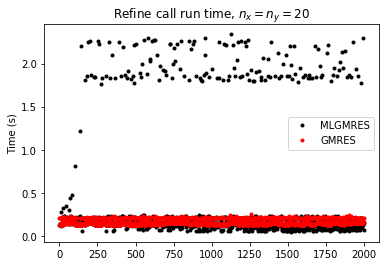

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=20$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.png')

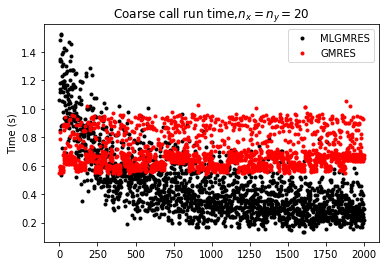

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=20$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


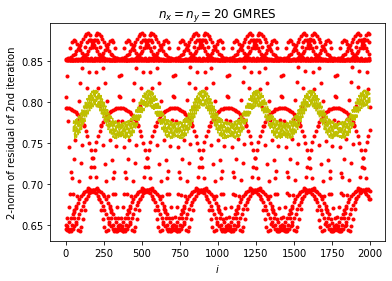

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[50:-1],AVG[50:-1],'--y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=20$ GMRES')
pp.savefig('GMRES.png')

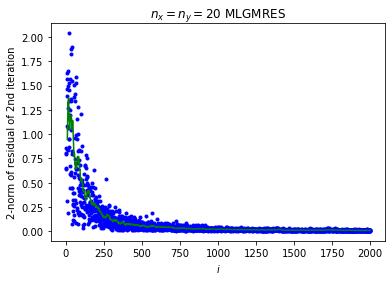

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=20$ MLGMRES')
pp.savefig('MLGMRES.png')

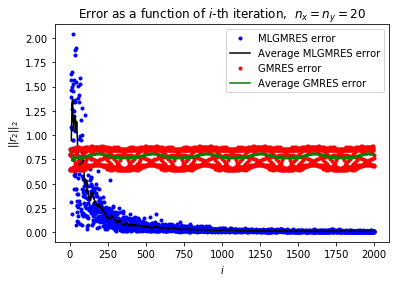

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,  $n_x=n_y=20$ ')
pp.legend(loc='best')
pp.savefig('Compare.png')

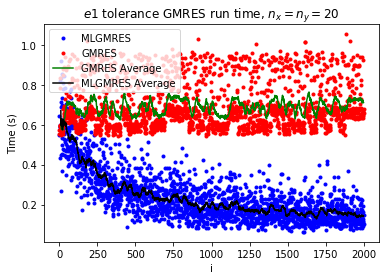

In [15]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=20$')
pp.legend(loc='best')
pp.savefig('Runtime.png')

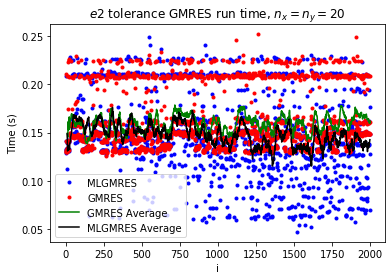

In [16]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=20$')
pp.legend(loc='best')
pp.savefig('Runtime2.png')

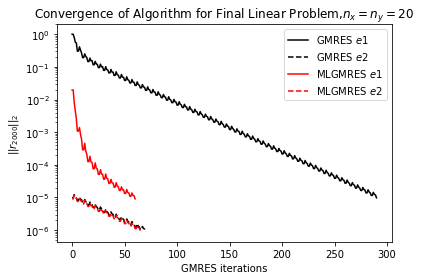

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r_{2000}||_2$')
pp.title('Convergence of Algorithm for Final Linear Problem,$n_x=n_y=20$')
pp.savefig('Error.png')